## Mini Project 1 notebook

### Importations 

In [2]:
#!/usr/bin/env python

import torch

import dlc_practical_prologue as prologue

from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F


print(torch.__version__)

train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)


In [3]:
import matplotlib.pyplot as plt

In [4]:
import cv2

### Goal

Let's have some insight about the data and what we are supposed to do.

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. 

We have too implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

### Insight on the data

First we want to visualize a pair of 14 x 14 grayscale image. 

We load the first pair and diplay it using matplotlib

In [5]:
train_input.shape

torch.Size([1000, 2, 14, 14])

In [6]:
pair = train_input[0]

In [7]:
pair.shape

torch.Size([2, 14, 14])

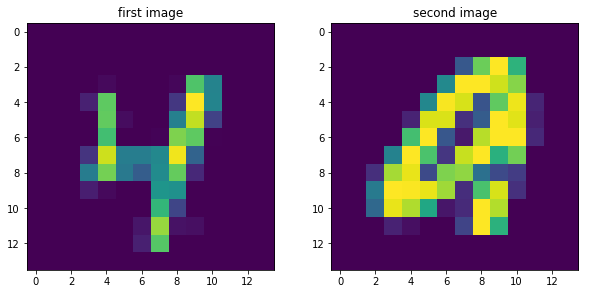

In [8]:
plt.figure(figsize=(10,10))
           
plt.subplot(2,2,1)
plt.imshow(pair[0])
plt.title('first image')


plt.subplot(2,2,2)
plt.imshow(pair[1])
plt.title('second image')


plt.show()

In [9]:
train_target[0]

tensor(1)

Let's have a look at their corresponding labels.

In [10]:
train_classes[0]

tensor([4, 9])

Note that the corresponding classes from our first pair are 4 and 9 which is consistent with the images we had. However we can see that the quality of the image is poor and hard to read from human perspective.

# Architecture 1.0 : vanilla CNN to recognize digits 

In this section, we will focus on building a vanilla CNN in order to recognize the digits from each image from each pairs. Once done, we will then compare "by hand" the comparision between the predicted pair. This is the most basic setup and will try to improve latter.

## 1.1 Creating Model

In [11]:
class Net(nn.Module):
    def __init__(self,nb_hidden = 200):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [12]:
class Net2(nn.Module):
    def __init__(self,nb_hidden = 200):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
    

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.fc2(x)
        return x

We need to prepare the data to feed the model.

In [13]:
def prep_input_vanilla(train_input):
    new_train_input = train_input.view(2000,-1,14,14)
    return new_train_input

In [14]:
def prep_target_vanilla(train_classes):
    
    train_classes = train_classes.flatten()
    
    stack = torch.tensor([0.0]*10)
    
    for i in train_classes:
        current = torch.tensor([0.0]*10)
        current[i.item()] = 1
        stack = torch.cat([stack.view(-1,10),current.view(-1,10)])
        
    return stack[1:]
        

### Begin of Sanity check:

In [15]:
t = prep_input_vanilla(train_input)
t.shape

torch.Size([2000, 1, 14, 14])

In [16]:
t[0].shape

torch.Size([1, 14, 14])

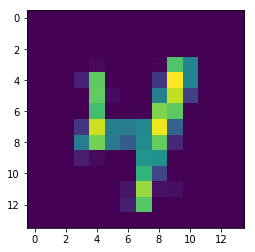

In [17]:
plt.imshow(t[0].view(14,14))

In [18]:
l = prep_target_vanilla(train_classes)
l.shape

torch.Size([2000, 10])

In [19]:
l[0]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

### End of sanity check

## 1.2 Training the model

In [20]:
mini_batch_size = 100 
nb_epochs = 25
eta = 0.001 #learning rate
#criterion = nn.MSELoss() # loss
criterion = torch.nn.CrossEntropyLoss()

In [21]:
def train_model(model, train_input, train_target, mini_batch_size, criterion, nb_epochs, eta):
    
    optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = 0.9) #Stochastic gradient descent
    
    for e in range(0, nb_epochs):
        sum_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            target = train_target.narrow(0, b, mini_batch_size)
            #loss = criterion(output,target) FOR MSE
            loss = criterion(output,target.max(1)[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(e, loss.data.item())
    

In [22]:
model = Net()

train_input_1 = prep_input_vanilla(train_input)
train_target_1 = prep_target_vanilla(train_classes)
train_input_1, train_target_1 = Variable(train_input_1), Variable(train_target_1)

In [23]:
train_model(model,train_input_1,train_target_1,mini_batch_size,criterion,nb_epochs,eta)

0 1.905784010887146
1 1.1471551656723022
2 0.8657879829406738
3 0.6453748941421509
4 0.5745720863342285
5 0.45835578441619873
6 0.3829100728034973
7 0.33625638484954834
8 0.29045331478118896
9 0.26864632964134216
10 0.25782883167266846
11 0.24233341217041016
12 0.23748263716697693
13 0.22638721764087677
14 0.24905818700790405
15 0.2453775405883789
16 0.19448457658290863
17 0.1586073487997055
18 0.13742578029632568
19 0.16230274736881256
20 0.2107744961977005
21 0.164866104722023
22 0.1676257848739624
23 0.20136228203773499
24 0.20115028321743011


## 1.3 Testing the model

In [24]:
def compute_nb_errors(model, input_, target, mini_batch_size):
    
    nb_errors = 0
    
    for b in range(0, input_.size(0), mini_batch_size):
        output = model(input_.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        for k in range(mini_batch_size):
            if target.data[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1
    
    return nb_errors

In [25]:
test_input_1 = prep_input_vanilla(test_input)
test_target_1 = prep_target_vanilla(test_classes)

In [26]:
compute_nb_errors(model,test_input_1,test_target_1,mini_batch_size)

174

In [27]:
compute_nb_errors(model,train_input_1,train_target_1,mini_batch_size)

54

In [28]:
train_input_1.shape

torch.Size([2000, 1, 14, 14])

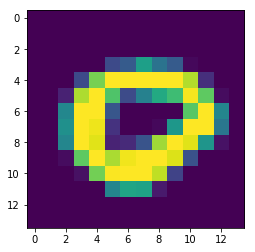

In [29]:
plt.imshow(test_input_1[131].view(14,14))

In [30]:
model(test_input_1[131].view(1,1,14,14)).max(1)[1].item()

0

In [31]:
test_classes.flatten()[131]

tensor(0)

## 1.4 Comparing the n pairs

In [32]:
def compare_pair(test_input):
    a = test_input[0]
    b = test_input[1]
    
    val_a = model(a.view(1,1,14,14)).max(1)[1].item()
    val_b = model(b.view(1,1,14,14)).max(1)[1].item()
    
    if(val_a > val_b):
        return 0
    else:
        return 1

In [33]:
pred = torch.tensor([compare_pair(x) for x in test_input])

In [34]:
errors = torch.abs(pred-test_target).sum()

In [35]:
print('there is {:d} errors over 1000.'.format(errors.item()))

there is 60 errors over 1000.


### sanity check and parameters loading

parameters : eta = 0.01 epoch = 25 batch size = 200 criterion = maxEntropy
             eta = 0.001 epoch = 25 batch size = 200 criterion = maxEntropy

In [225]:
a = test_input[178][0]
b = test_input[178][1]

In [226]:
val_a = model(a.view(1,1,14,14)).max(1)[1].item()
val_b = model(b.view(1,1,14,14)).max(1)[1].item()

In [227]:
val_a

6

In [228]:
val_b

6

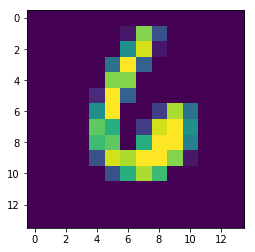

In [229]:
plt.imshow(a)

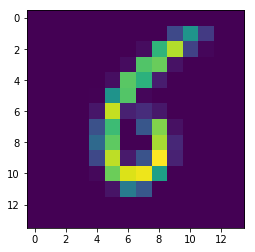

In [230]:
plt.imshow(b)

## 2.0 Architecture 